In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '../commodities_data.csv'

df = pd.read_csv(file_path)

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [4]:
class_counts = df.groupby('item.class')['item.id'].nunique()
df.info()
print(class_counts)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79852830 entries, 0 to 79852829
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          int64         
 1   quantity    int64         
 2   unit_price  int64         
 3   time_left   object        
 4   item.id     int64         
 5   item.name   object        
 6   item.class  object        
 7   datetime    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 4.8+ GB
item.class
Armor              11
Consumables      3201
Gems             1003
Glyphs            111
Miscellaneous    1979
Recipes             3
Trade Goods      2093
Unknown           701
Name: item.id, dtype: int64


,id,quantity,unit_price,time_left,item.id,item.name,item.class,datetime
0,1899749198,15,109400,SHORT,184090,Potion of the Psychopomp's Speed,Consumables,2023-12-28 15:41:00
1,1899749311,1,2000,SHORT,168650,Cragscale,Trade Goods,2023-12-28 15:41:00
2,1899749353,6,2400,SHORT,152576,Tidespray Linen,Trade Goods,2023-12-28 15:41:00
3,1899749415,2,290200,SHORT,76885,Burning Primal Diamond,Gems,2023-12-28 15:41:00
4,1899749701,1,9707000,SHORT,139362,Glyph of Mana Touched Souls,Glyphs,2023-12-28 15:41:00


In [5]:
# Replace 'Unknown' with NaN for item.name and item.class
df['item.name'] = df['item.name'].replace('Unknown', pd.NA)
df['item.class'] = df['item.class'].replace('Unknown', pd.NA)

total_items = len(df)

missing_name = len(df[df['item.name'].isna()])
missing_class = len(df[df['item.class'].isna()])
missing_both = len(df[df['item.name'].isna() & df['item.class'].isna()])

print(f"Total rows: {total_items:,}")
print(f"Rows missing name: {missing_name:,}")
print(f"Rows missing class: {missing_class:,}")
print(f"Rows missing both name and class: {missing_both:,}")

Total rows: 79,852,830
Rows missing name: 6,902
Rows missing class: 7,323,232
Rows missing both name and class: 6,902


In [6]:
# Drop rows where either 'item.name' or 'item.class' is NA
cleaned_df = df.dropna(subset=['item.name', 'item.class'])

Percentage of 'junk' items: 6.28%


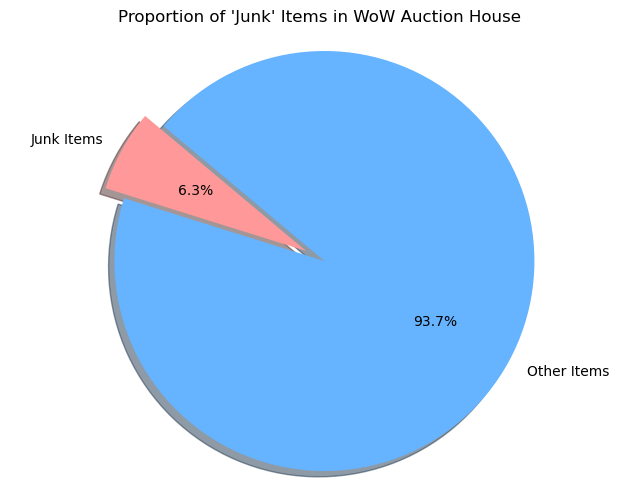

In [7]:
# set threshold for 'junk' items
high_quantity_threshold = cleaned_df['quantity'].quantile(0.75)  # top 25% of quantities
low_price_threshold = cleaned_df['unit_price'].quantile(0.25)  # bottom 25% of prices

junk_items_df = cleaned_df[(cleaned_df['quantity'] >= high_quantity_threshold) &
                           (cleaned_df['unit_price'] <= low_price_threshold)] # 'junk' items satisfy both conditions

total_items = len(cleaned_df)
junk_items_count = len(junk_items_df)
junk_percentage = (junk_items_count / total_items) * 100
print(f"Percentage of 'junk' items: {junk_percentage:.2f}%")

labels = ['Junk Items', 'Other Items']
sizes = [junk_items_count, total_items - junk_items_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0) 

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.axis('equal')
plt.title("Proportion of 'Junk' Items in WoW Auction House")
plt.show()

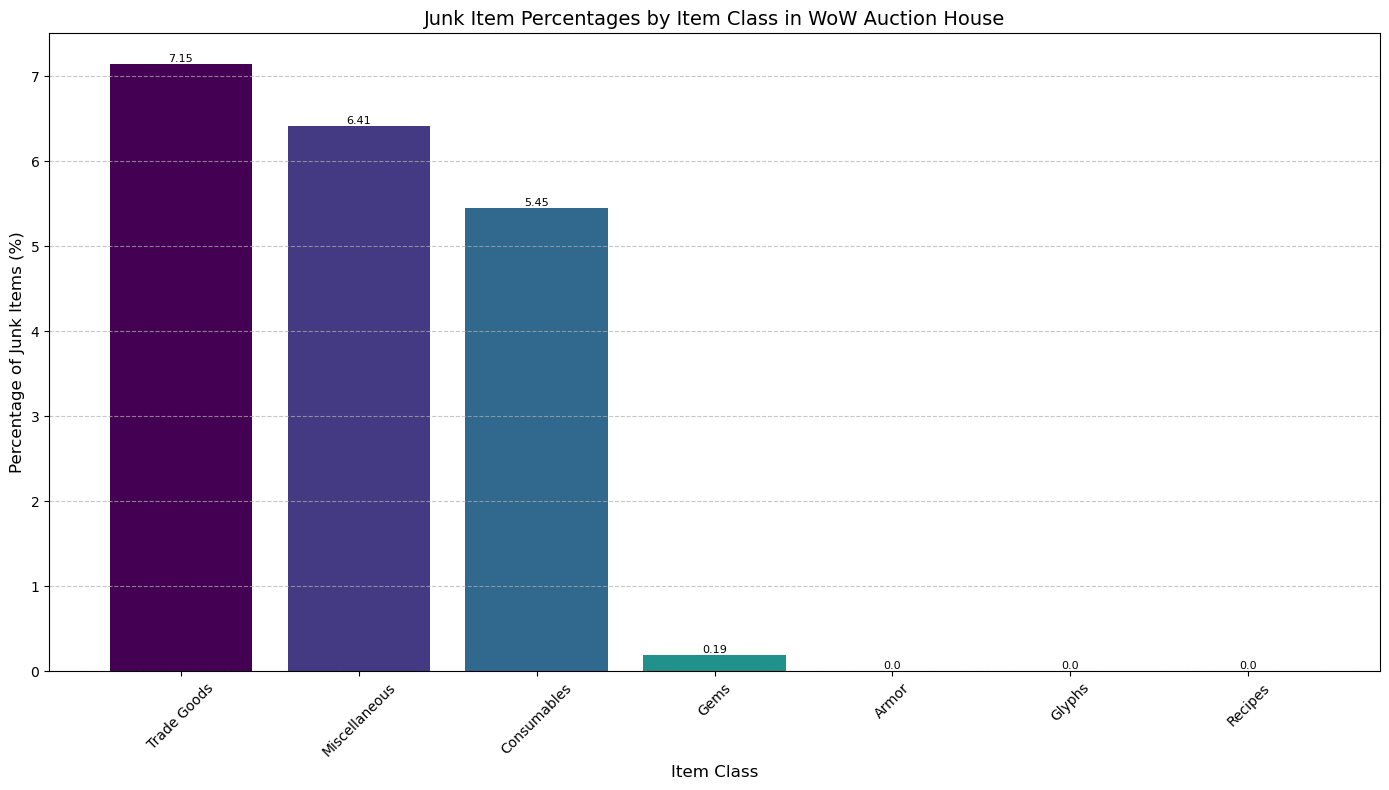

In [8]:
total_counts_by_class = cleaned_df.groupby('item.class').size()
junk_counts_by_class = junk_items_df.groupby('item.class').size()

junk_percentage_by_class = (junk_counts_by_class / total_counts_by_class) * 100

junk_percentage_by_class = junk_percentage_by_class.fillna(0)

sorted_junk_percentages = junk_percentage_by_class.sort_values(ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(sorted_junk_percentages.index, sorted_junk_percentages, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_junk_percentages))))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=8)

plt.xlabel('Item Class', fontsize=12)
plt.ylabel('Percentage of Junk Items (%)', fontsize=12)
plt.title('Junk Item Percentages by Item Class in WoW Auction House', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



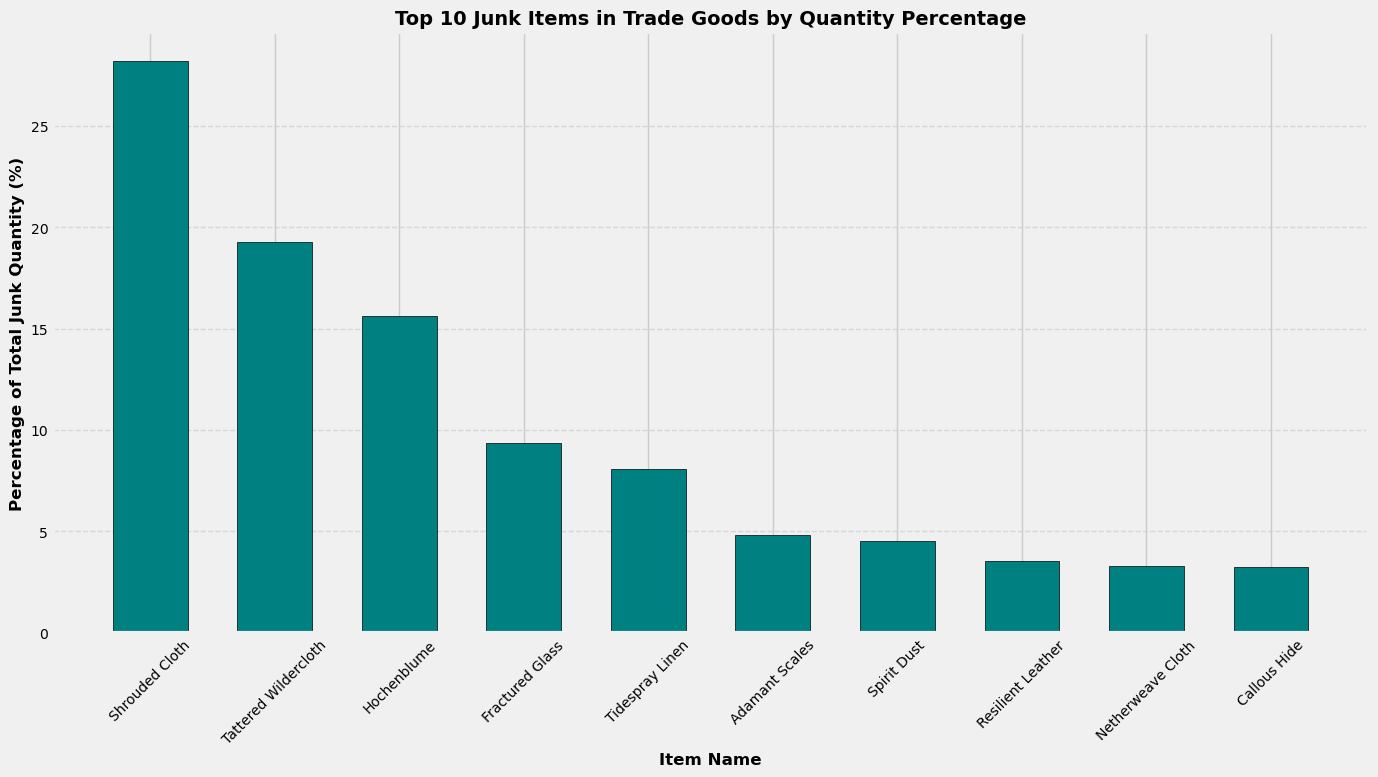

In [9]:
trade_goods_df = cleaned_df[cleaned_df['item.class'] == 'Trade Goods']
junk_in_trade_goods = trade_goods_df[(trade_goods_df['quantity'] >= high_quantity_threshold) & 
                                     (trade_goods_df['unit_price'] <= low_price_threshold)]

junk_item_quantities = junk_in_trade_goods.groupby('item.name')['quantity'].sum()
sorted_junk_items = junk_item_quantities.sort_values(ascending=False)
top_n = 10
top_junk_items = sorted_junk_items.head(top_n)

total_junk_quantity = top_junk_items.sum()
top_junk_items_percentage = (top_junk_items / total_junk_quantity) * 100

plt.style.use('fivethirtyeight')

plt.figure(figsize=(14, 8))
bars = plt.bar(top_junk_items_percentage.index, top_junk_items_percentage, color='teal', edgecolor='black', width=0.6)

plt.xlabel('Item Name', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Total Junk Quantity (%)', fontsize=12, fontweight='bold')
plt.title('Top 10 Junk Items in Trade Goods by Quantity Percentage', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

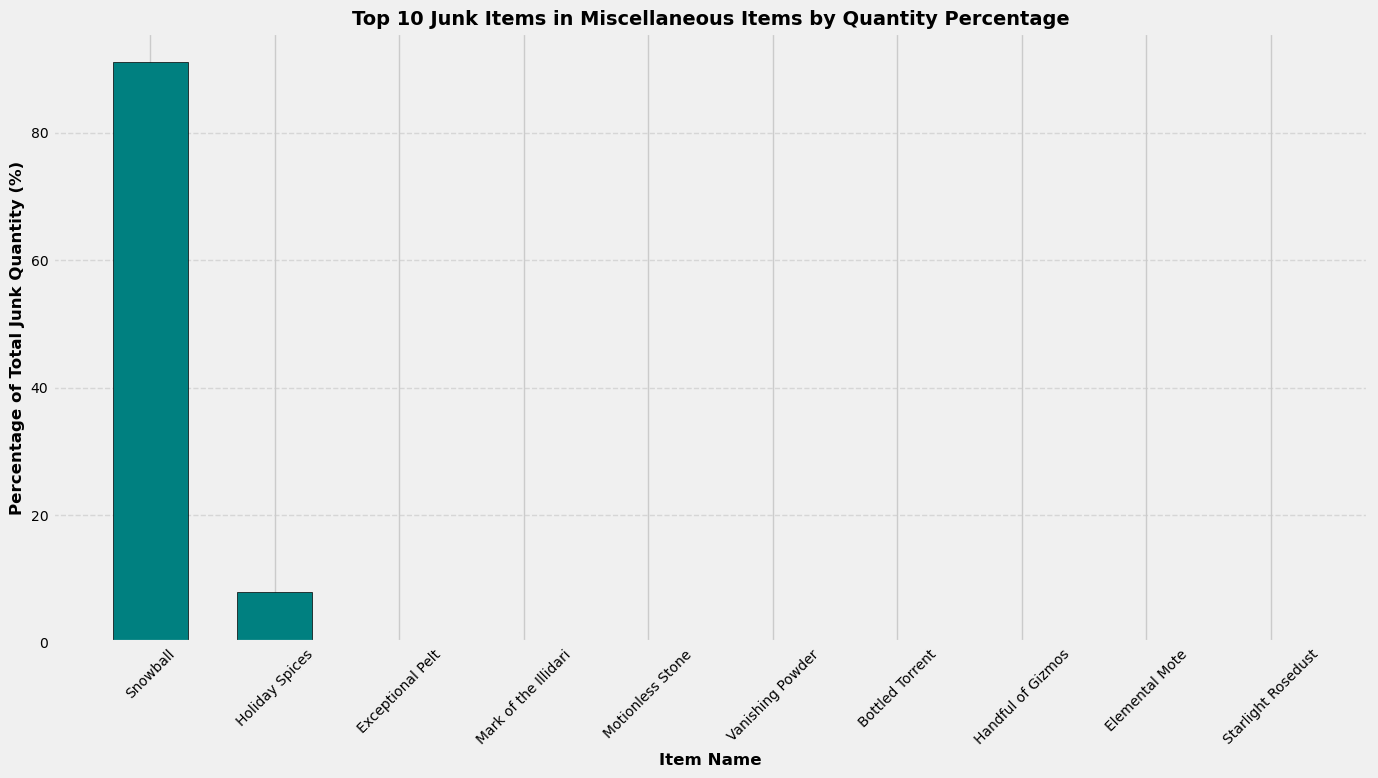

In [10]:
miscellaneous_df = cleaned_df[cleaned_df['item.class'] == 'Miscellaneous']
junk_in_miscellaneous = miscellaneous_df[(miscellaneous_df['quantity'] >= high_quantity_threshold) & 
                                     (miscellaneous_df['unit_price'] <= low_price_threshold)]

junk_item_quantities = junk_in_miscellaneous.groupby('item.name')['quantity'].sum()
sorted_junk_items = junk_item_quantities.sort_values(ascending=False)
top_n = 10
top_junk_items = sorted_junk_items.head(top_n)

total_junk_quantity = top_junk_items.sum()
top_junk_items_percentage = (top_junk_items / total_junk_quantity) * 100

plt.style.use('fivethirtyeight')

plt.figure(figsize=(14, 8))
bars = plt.bar(top_junk_items_percentage.index, top_junk_items_percentage, color='teal', edgecolor='black', width=0.6)

plt.xlabel('Item Name', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Total Junk Quantity (%)', fontsize=12, fontweight='bold')
plt.title('Top 10 Junk Items in Miscellaneous Items by Quantity Percentage', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

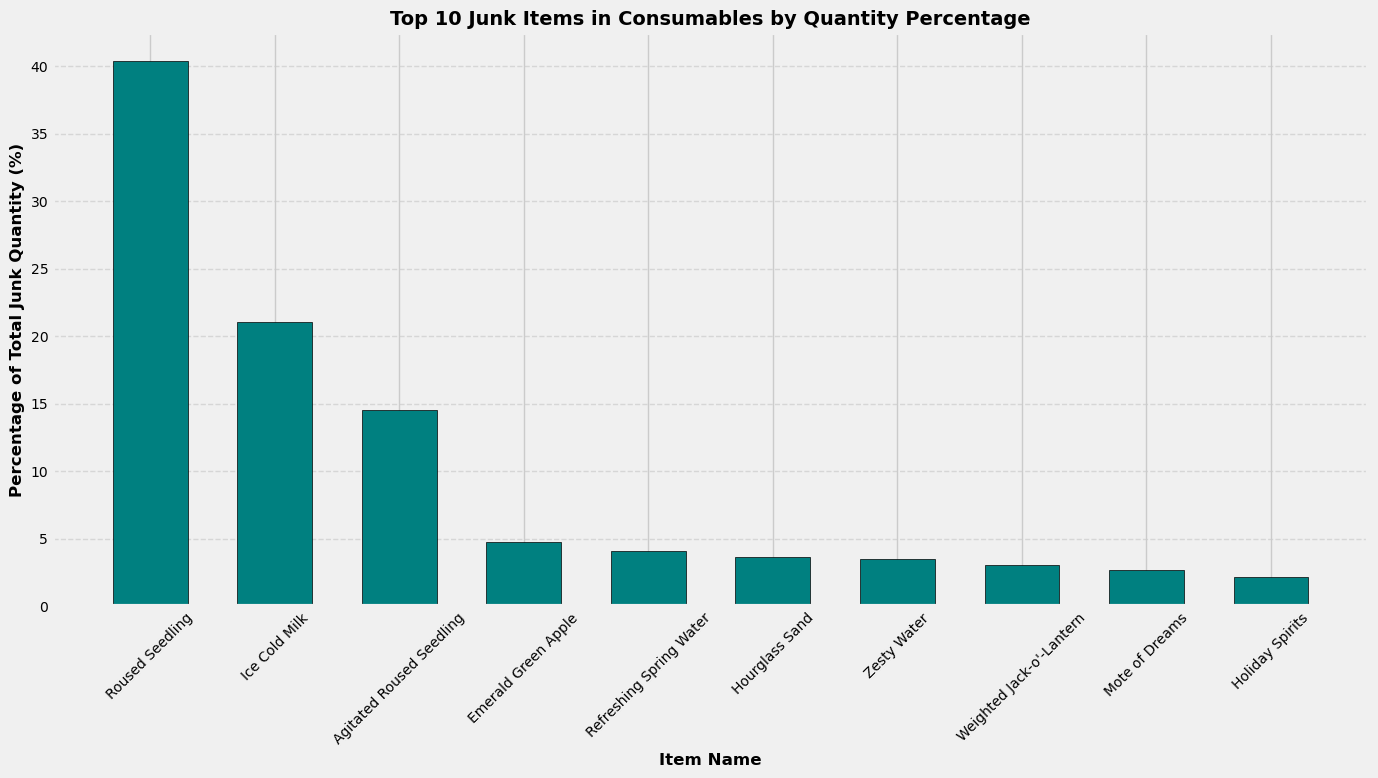

In [11]:
consumables_df = cleaned_df[cleaned_df['item.class'] == 'Consumables']
junk_in_consumables = consumables_df[(consumables_df['quantity'] >= high_quantity_threshold) & 
                                     (consumables_df['unit_price'] <= low_price_threshold)]

junk_item_quantities = junk_in_consumables.groupby('item.name')['quantity'].sum()
sorted_junk_items = junk_item_quantities.sort_values(ascending=False)
top_n = 10
top_junk_items = sorted_junk_items.head(top_n)

total_junk_quantity = top_junk_items.sum()
top_junk_items_percentage = (top_junk_items / total_junk_quantity) * 100

plt.style.use('fivethirtyeight')

plt.figure(figsize=(14, 8))
bars = plt.bar(top_junk_items_percentage.index, top_junk_items_percentage, color='teal', edgecolor='black', width=0.6)

plt.xlabel('Item Name', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Total Junk Quantity (%)', fontsize=12, fontweight='bold')
plt.title('Top 10 Junk Items in Consumables by Quantity Percentage', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

In [12]:
junk_items_df = junk_items_df.copy()

# Extract day of the week and hour from the datetime
junk_items_df['day_of_week'] = junk_items_df['datetime'].dt.day_name()
junk_items_df['hour_of_day'] = junk_items_df['datetime'].dt.hour


In [13]:
quantity_by_day = junk_items_df.groupby('day_of_week')['quantity'].sum()



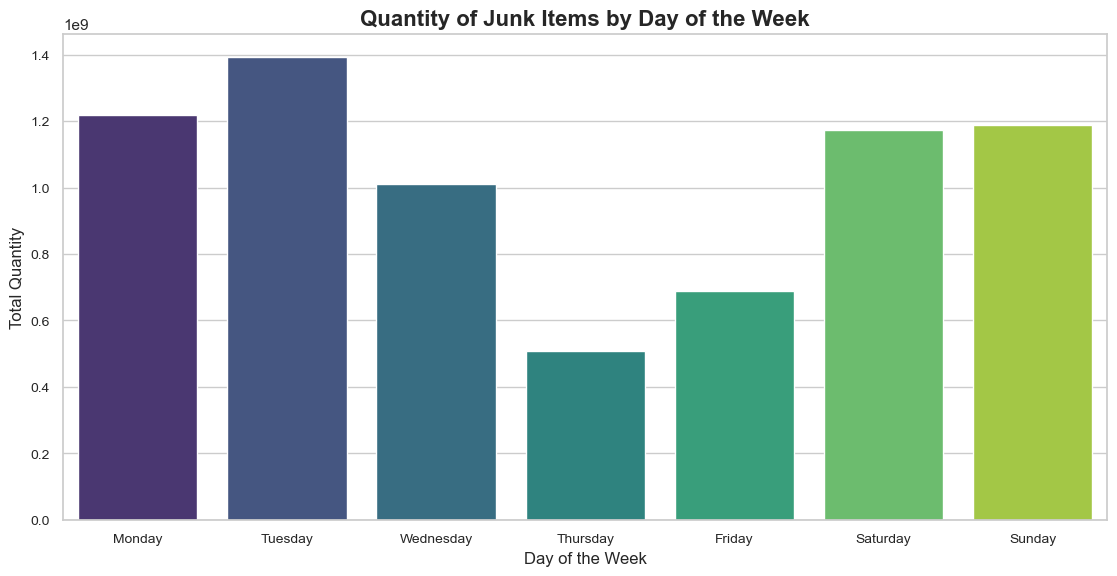

In [14]:
# Days ordered from Monday to Sunday for plotting
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
quantity_by_day = quantity_by_day.reindex(ordered_days)

sns.set(style="whitegrid")

# Days ordered from Monday to Sunday for plotting
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
quantity_by_day = quantity_by_day.reindex(ordered_days)

plt.figure(figsize=(12, 6))
sns.barplot(x=quantity_by_day.index, y=quantity_by_day.values, palette="viridis")
plt.title('Quantity of Junk Items by Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

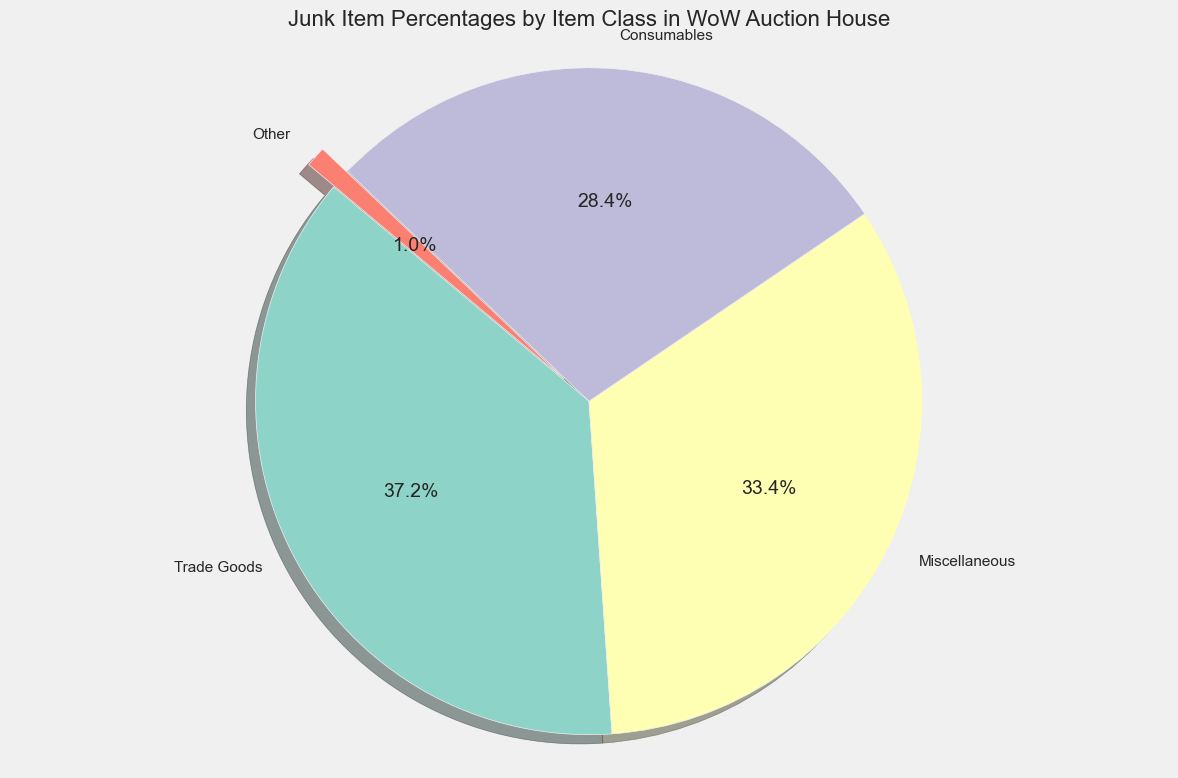

In [28]:
import matplotlib.cm as cm

# Assuming sorted_junk_percentages is your Series with item class percentages
# Aggregate smaller categories into 'Other'
small_categories = sorted_junk_percentages[sorted_junk_percentages < 2]
other_percentage = small_categories.sum()
filtered_junk_percentages = sorted_junk_percentages[sorted_junk_percentages >= 2]
filtered_junk_percentages['Other'] = other_percentage

labels = filtered_junk_percentages.index
sizes = filtered_junk_percentages.values
explode = [0.1 if label == 'Other' else 0 for label in labels] 

colors = cm.Set3.colors

plt.style.use('fivethirtyeight')

#  pie chart
plt.figure(figsize=(12, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)

plt.title('Junk Item Percentages by Item Class in WoW Auction House', fontsize=16)
plt.axis('equal')  
plt.tight_layout()
plt.show()




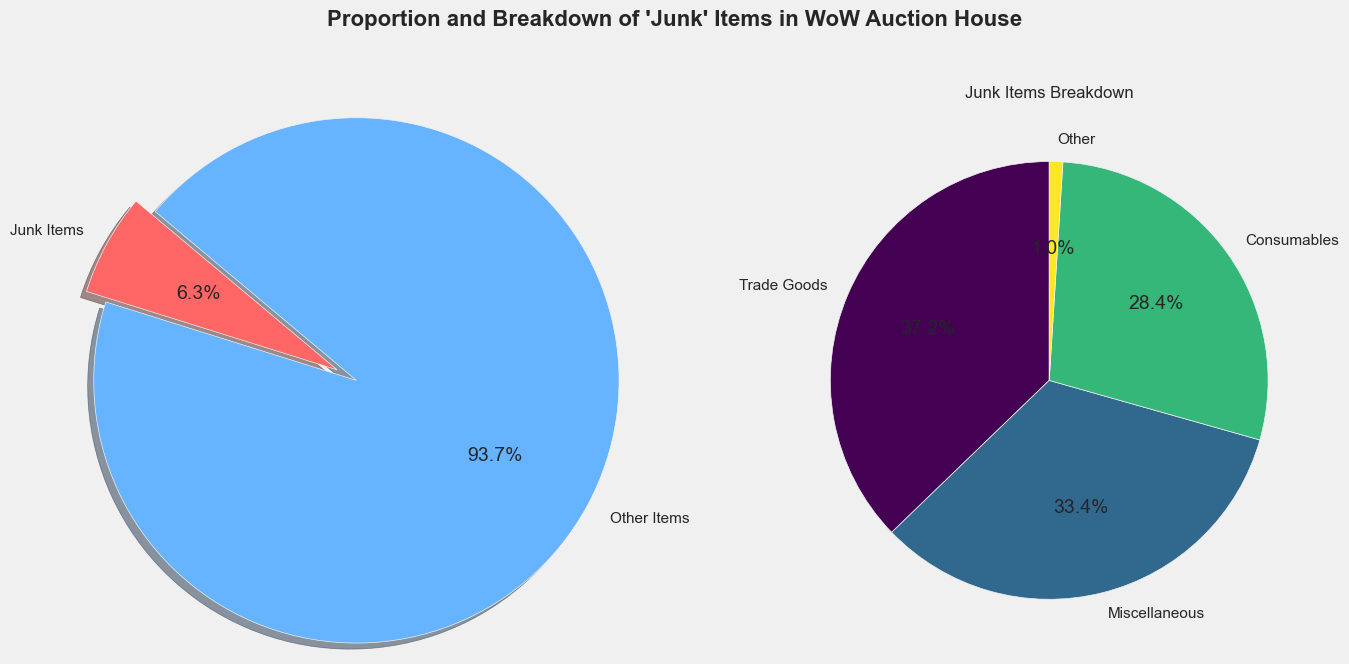

In [29]:
import matplotlib.cm as cm

primary_labels = ['Junk Items', 'Other Items']
primary_sizes = [junk_items_count, total_items - junk_items_count]
primary_colors = ['#ff6666', '#66b3ff']
primary_explode = (0.1, 0)  # explode 'Junk Items'

secondary_labels = filtered_junk_percentages.index
secondary_sizes = filtered_junk_percentages.values
secondary_colors = cm.viridis(np.linspace(0, 1, len(secondary_labels)))  # Gradients

plt.figure(figsize=(14, 7))
plt.suptitle("Proportion and Breakdown of 'Junk' Items in WoW Auction House", fontsize=16, fontweight='bold')

# primary pie
ax1 = plt.subplot(121)
ax1.pie(primary_sizes, labels=primary_labels, autopct='%1.1f%%', startangle=140, 
        colors=primary_colors, explode=primary_explode, radius=1.2, shadow=True)

# secondary pie
ax2 = plt.subplot(122)
ax2.pie(secondary_sizes, labels=secondary_labels, autopct='%1.1f%%', 
                 colors=secondary_colors, startangle=90)
ax2.set_title('Junk Items Breakdown', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()





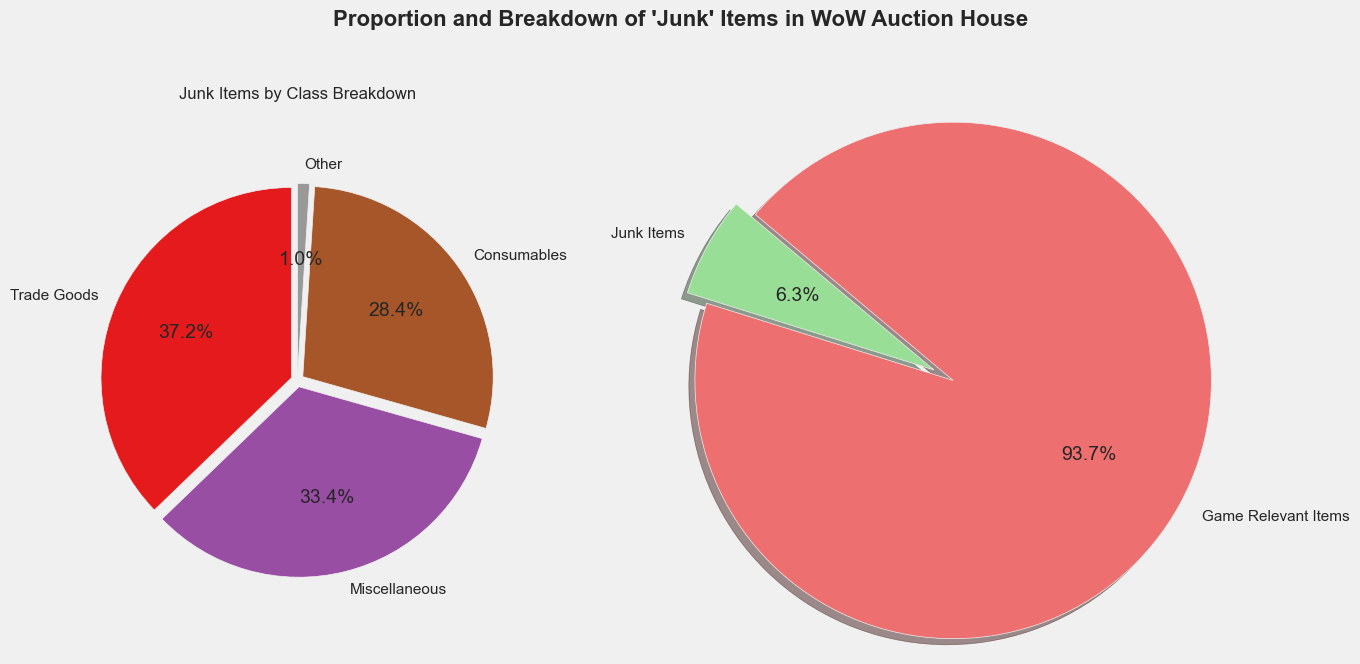

In [53]:
primary_labels = ['Junk Items', 'Game Relevant Items']
primary_sizes = [junk_items_count, total_items - junk_items_count]

primary_colors = ['#99de97', '#ed6f6f']

primary_explode = (0.1, 0)

secondary_labels = filtered_junk_percentages.index
secondary_sizes = filtered_junk_percentages.values
secondary_colors = cm.Set1(np.linspace(0, 1, len(secondary_labels)))
secondary_explode = (.03, .03, .03, .03)

plt.figure(figsize=(14, 7))
plt.suptitle("Proportion and Breakdown of 'Junk' Items in WoW Auction House",
             fontsize=16, fontweight='bold')

# primary
ax1 = plt.subplot(122)
ax1.pie(primary_sizes, labels=primary_labels, autopct='%1.1f%%', startangle=140,
        colors=primary_colors, explode=primary_explode, radius=1.18, shadow=True)  # Slightly larger primary chart

# secondary
ax2 = plt.subplot(121)
ax2.pie(secondary_sizes, labels=secondary_labels, autopct='%1.1f%%',
        colors=secondary_colors, startangle=90, explode=secondary_explode, radius=0.87)  # 10% smaller secondary chart
ax2.set_title('Junk Items by Class Breakdown', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()